In [1]:
#inspo: https://www.kaggle.com/ravi72munde/uber-lyft-cab-prices

# Predicting Uber and Lyft Prices in Boston, MA

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor

# Data Cleaning

In [3]:
fp = os.path.join('data', 'cab_rides.csv')
data = pd.read_csv(fp)
data.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [4]:
fp2 = os.path.join('data', 'weather.csv')
weather = pd.read_csv(fp2)
weather.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49


In [5]:
#appears that we have some rides with missing estimated prices
data.info()
data = data.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   distance          693071 non-null  float64
 1   cab_type          693071 non-null  object 
 2   time_stamp        693071 non-null  int64  
 3   destination       693071 non-null  object 
 4   source            693071 non-null  object 
 5   price             637976 non-null  float64
 6   surge_multiplier  693071 non-null  float64
 7   id                693071 non-null  object 
 8   product_id        693071 non-null  object 
 9   name              693071 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 52.9+ MB


In [6]:
#appears to be null values in the 'rain' column, perhaps it didn't rain these days, data is missing by design
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6276 entries, 0 to 6275
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp        6276 non-null   float64
 1   location    6276 non-null   object 
 2   clouds      6276 non-null   float64
 3   pressure    6276 non-null   float64
 4   rain        894 non-null    float64
 5   time_stamp  6276 non-null   int64  
 6   humidity    6276 non-null   float64
 7   wind        6276 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 392.4+ KB


In [7]:
#convert timestamps to date time objects
data['time_stamp'] = pd.to_datetime(data['time_stamp']/1000, unit = 's').dt.floor('s')
weather['time_stamp'] = pd.to_datetime(weather['time_stamp'], unit = 's')

In [8]:
#create column reflecting location, date, and time of day to merge weather data
data['merge_stamp'] = data['source'] + ' ' + data['time_stamp'].dt.date.astype(str) + ' ' + data['time_stamp'].dt.hour.astype(str)
weather['merge_stamp'] = weather['location'] + ' ' + weather['time_stamp'].dt.date.astype(str) + ' ' + weather['time_stamp'].dt.hour.astype(str)

In [9]:
#merge data and weather tables and drop redundant/unecessary columns for analysis
weather['merge_stamp'] = weather['merge_stamp'].drop_duplicates()
df = pd.merge(data, weather, on = 'merge_stamp')
df = df.drop(columns = ['time_stamp_y', 'merge_stamp', 'location', 'id', 'product_id'], axis = 1)
df.head()

,distance,cab_type,time_stamp_x,destination,source,price,surge_multiplier,name,temp,clouds,pressure,rain,humidity,wind
0,0.44,Lyft,2018-12-16 09:30:07,North Station,Haymarket Square,5.0,1.0,Shared,38.46,0.29,1022.25,NaN,0.76,7.68
1,1.33,Lyft,2018-12-16 09:25:09,Beacon Hill,Haymarket Square,7.0,1.0,Lyft,38.46,0.29,1022.25,NaN,0.76,7.68
2,0.53,Lyft,2018-12-16 09:05:09,North Station,Haymarket Square,27.5,1.0,Lux Black XL,38.46,0.29,1022.25,NaN,0.76,7.68
3,2.36,Lyft,2018-12-16 09:55:08,Back Bay,Haymarket Square,7.0,1.0,Shared,38.46,0.29,1022.25,NaN,0.76,7.68
4,0.62,Uber,2018-12-16 09:55:08,West End,Haymarket Square,10.5,1.0,UberXL,38.46,0.29,1022.25,NaN,0.76,7.68


In [10]:
#fill missing 'rain' values with 0, this data is missing by design, as it didn't rain
df['rain'].fillna(0, inplace = True)
df.isnull().sum()

distance            0
cab_type            0
time_stamp_x        0
destination         0
source              0
price               0
surge_multiplier    0
name                0
temp                0
clouds              0
pressure            0
rain                0
humidity            0
wind                0
dtype: int64

# Baseline Model

In [117]:
#we will now construct the baseline model for predicting the estimated price of an uber/lyft ride

In [118]:
df.head()

,distance,cab_type,time_stamp_x,destination,source,price,surge_multiplier,name,temp,clouds,pressure,rain,humidity,wind
0,0.44,Lyft,2018-12-16 09:30:07,North Station,Haymarket Square,5.0,1.0,Shared,38.46,0.29,1022.25,0.0,0.76,7.68
1,1.33,Lyft,2018-12-16 09:25:09,Beacon Hill,Haymarket Square,7.0,1.0,Lyft,38.46,0.29,1022.25,0.0,0.76,7.68
2,0.53,Lyft,2018-12-16 09:05:09,North Station,Haymarket Square,27.5,1.0,Lux Black XL,38.46,0.29,1022.25,0.0,0.76,7.68
3,2.36,Lyft,2018-12-16 09:55:08,Back Bay,Haymarket Square,7.0,1.0,Shared,38.46,0.29,1022.25,0.0,0.76,7.68
4,0.62,Uber,2018-12-16 09:55:08,West End,Haymarket Square,10.5,1.0,UberXL,38.46,0.29,1022.25,0.0,0.76,7.68


In [119]:
#drop colinear columns

In [120]:
X = df.drop(columns = ['cab_type', 'price', 'destination'])
y = df['price']

In [35]:
def name_ordinal(df):
    if type(df)!=pd.core.frame.DataFrame: df = pd.DataFrame(df)
    def ord_helper(x):
        x = x.lower()
        if ('uberpool' == x) or ('shared' == x): return 0
        elif ('uberx' == x) or ('lyft' == x) or ('wav' == x): return 1
        elif ('uberxl' == x) or ('lyft xl' == x): return 2
        elif ('black' == x) or ('lux' == x): return 3
        elif ('lux black' == x): return 4
        else: return 5
    d = df.applymap(ord_helper)
    return d

def extract_timeday(df):
    if type(df)!=pd.core.frame.DataFrame: df = pd.DataFrame(df)
    def helper(x):
        hour = x.hour
        if (hour >= 6) and (hour <= 12): return 0
        elif (hour > 12) and (hour <= 4): return 1
        elif (hour > 4) and (hour <= 8): return 2
        else: return 3
    d = df.applymap(helper)
    return d

In [125]:
ohe_transformer = OneHotEncoder(sparse=False, handle_unknown='ignore')
cat_transformer = Pipeline(steps=[('encode', ohe_transformer),
                                 ('pca', PCA(svd_solver = 'full'))])
name_transformer = FunctionTransformer(name_ordinal, validate = False)
time_transformer = FunctionTransformer(extract_timeday, validate = False)
num_transformer = Pipeline(steps=[('standardize', StandardScaler())])

preproc = ColumnTransformer(transformers=[\
                        ('categorical', cat_transformer, ['source']),
                        ('name', name_transformer, ['name']),
                        ('time', time_transformer, ['time_stamp_x']),
                        ('numerical', num_transformer, ['distance', 'temp', 'clouds',
                                                       'pressure', 'rain', 'humidity',
                                                       'wind'])
                        ], remainder = 'passthrough')

pl = Pipeline(steps=[
                     ('preprocessing', preproc), \
                     ('regression', LinearRegression())\
                    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 24)
pl.fit(X_train, y_train)
preds = pl.predict(X_test)

In [126]:
#determine regressor's root mean squared error
rmse = np.sqrt((preds - y_test).mean())
rmse

0.0904884851060216

In [127]:
#determine regressor's r2 score
r2 = pl.score(X_test, y_test)
r2

0.8979189945582976

In [128]:
#determine most important features for classification from baseline model
trans = pl.named_steps['preprocessing'].transformers_
cols = trans[0][1].named_steps['encode'].get_feature_names(['source'])
#regression coefficients
importance = pl['regression'].coef_
original = ['name', 'time_stamp', 'distance', 'temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind', 'surge']
cols = np.append(cols, original)
pd.DataFrame(importance, index = cols, columns = ['coefficient']).sort_values(by = 'coefficient', ascending = False)

,coefficient
source_West End,7.800917e+10
surge,1.699665e+01
name,4.711524e+00
distance,3.245290e+00
source_North Station,4.961007e-01
source_Boston University,3.297127e-01
source_Beacon Hill,2.844950e-01
source_Back Bay,1.950305e-01
source_Financial District,5.347302e-02
wind,1.761017e-02


In [40]:
#appears the weather data is the least important when making our predictions for uber/lyft prices

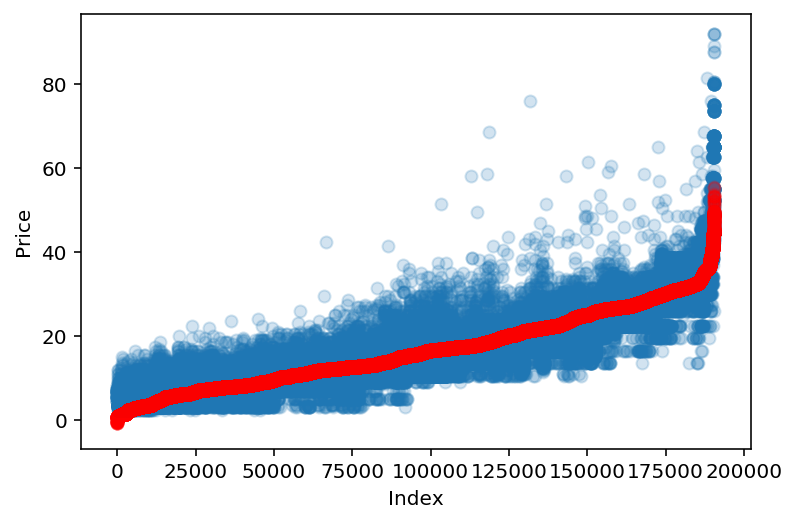

In [130]:
#scatterplot of data with multiple linear regression
output = pd.DataFrame({'pred': preds, 'actual': y_test})
output = output.sort_values(by='pred').reset_index(drop = True)
plt.scatter(output.index, output['actual'], alpha = 0.2)
plt.scatter(output.index, output['pred'], alpha = 0.2, color = 'r')
plt.ylabel('Price')
plt.xlabel('Index')
plt.show()

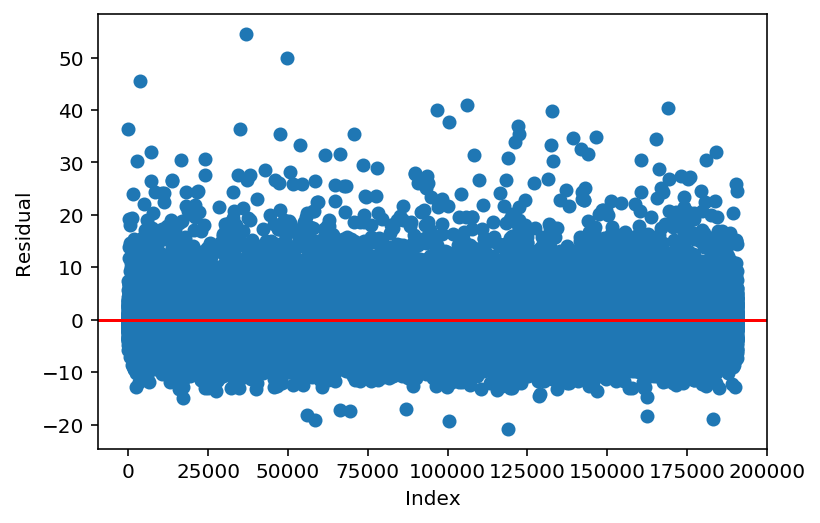

In [131]:
#graph residual plots
residuals = np.array(y_test - preds)
residuals = pd.DataFrame(residuals)
plt.scatter(residuals.index, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Index')
plt.ylabel('Residual')
plt.show()
#residuals don't appear to be equally spread above and below, there appears
#to be more variance in the positive region above the x-axis

# Final Model

In [132]:
#try log transforming the data and evaluate performance of decision tree regressor

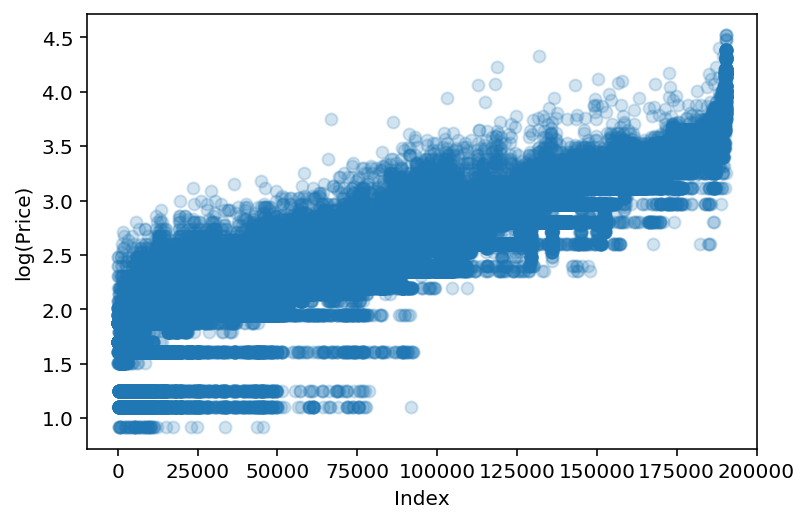

In [135]:
plt.scatter(output.index, np.log(output['actual']), alpha = 0.2)
plt.xlabel('Index')
plt.ylabel('log(Price)')
plt.show()

In [136]:
X = df.drop(columns = ['cab_type', 'price', 'destination',
                       'time_stamp_x', 'temp', 'clouds',
                       'pressure', 'rain', 'humidity', 'wind'])
y = np.log(df['price'])

In [137]:
X.head()

,distance,source,surge_multiplier,name
0,0.44,Haymarket Square,1.0,Shared
1,1.33,Haymarket Square,1.0,Lyft
2,0.53,Haymarket Square,1.0,Lux Black XL
3,2.36,Haymarket Square,1.0,Shared
4,0.62,Haymarket Square,1.0,UberXL


In [138]:
#create pipeline for final model
preproc = ColumnTransformer(transformers=[\
                        ('categorical', cat_transformer, ['source']),
                        ('name', name_transformer, ['name']),
                        ('numerical', num_transformer, ['distance'])
                        ], remainder = 'passthrough')

pl2 = Pipeline(steps=[
                     ('preprocessing', preproc), \
                     ('regression', DecisionTreeRegressor(max_depth = 15,
                                                          min_samples_leaf = 12))\
                    ])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 24)
pl2.fit(X_test, y_test)

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('categorical',
                                                  Pipeline(memory=None,
                                                           steps=[('encode',
                                                                   OneHotEncoder(categories='auto',
                                                                                 drop=None,
                                                                                 dtype=<class 'numpy.float64'>,
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False)),
                                

In [139]:
#cross validation to determine best parameters for engineered model
parameters = {
    'regression__min_samples_leaf': [12,13,15,17],
    'regression__max_depth': [11,13,15],
}

grid = GridSearchCV(pl2, parameters, cv = 3)
grid.fit(X_train,y_train)
preds2 = grid.predict(X_test)
grid.best_params_, grid.best_score_

({'regression__max_depth': 15, 'regression__min_samples_leaf': 12},
 0.944410462830497)

In [140]:
#root mean squared error
rmse = np.sqrt((preds2 - y_test).mean())
rmse

0.010188544007975265

In [141]:
#r2 score
r2 = pl2.score(X_test, y_test)
r2

0.9463603499765305

In [115]:
#rmse decreases and r2 score slightly increases from log transformation of data

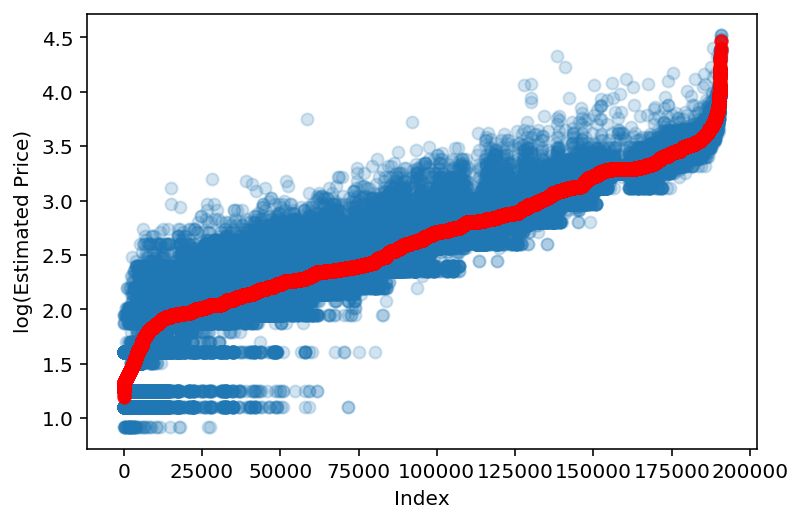

In [142]:
#scatterplot of data with multiple linear regression
output2 = pd.DataFrame({'pred': preds2, 'actual': y_test})
output2 = output2.sort_values(by='pred').reset_index(drop = True)
plt.scatter(output2.index, output2['actual'], alpha = 0.2)
plt.scatter(output2.index, output2['pred'], alpha = 0.2, color = 'r')
plt.xlabel('Index')
plt.ylabel('log(Estimated Price)')
plt.show()

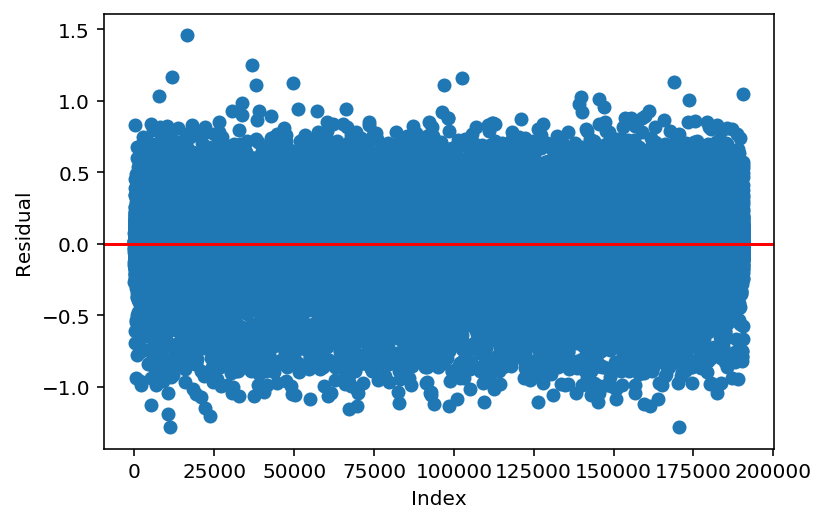

In [143]:
#graph residual plots
residuals2 = np.array(y_test - preds2)
residuals2 = pd.DataFrame(residuals2)
plt.scatter(residuals2.index, residuals2)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Index')
plt.ylabel('Residual')
plt.show()
#residuals appear to be more evenly distributed above and below x-axis